In [1]:
import pickle
import os
import matplotlib.pyplot as plt
import pandas as pd
from prepare_data import clean_string, split_by_name, create_triplet_samples, resolve_name_mismatches, reconcile_names
from dataset import VoiceFaceDataset
import numpy as np


In [2]:
%run download_data.py


Access denied with the following error:
Unzipping vfm_assignment.zip to vfm_assignment



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1HAk0yiiCKUT47i6l6kTW7Z3yovYCBdJW 



FileNotFoundError: [Errno 2] No such file or directory: 'vfm_assignment.zip'

In [3]:
# Define the path to the dataset
base_path = 'vfm_assignment'  # Adjust this path according to your environment

# Load image embeddings
with open(os.path.join(base_path, 'image_embeddings.pickle'), 'rb') as f:
    image_embeddings = pickle.load(f)

# Load audio embeddings
with open(os.path.join(base_path, 'audio_embeddings.pickle'), 'rb') as f:
    audio_embeddings = pickle.load(f)

# Display the type and length of the embeddings
print('Image embeddings:')
print(f'Type: {type(image_embeddings)}, Length: {len(image_embeddings)}')
print('Audio embeddings:')
print(f'Type: {type(audio_embeddings)}, Length: {len(audio_embeddings)}')


Image embeddings:
Type: <class 'dict'>, Length: 7129
Audio embeddings:
Type: <class 'dict'>, Length: 32090


In [4]:
# Example to check dimensions of embeddings
image_example = next(iter(image_embeddings.values()))
audio_example = next(iter(audio_embeddings.values()))

print(f'Dimensions of an image embedding vector: {image_example.shape}')
print(f'Dimensions of an audio embedding vector: {audio_example.shape}')

# Optionally, display keys to understand naming conventions
print("Example keys (image):", list(image_embeddings.keys())[:3])
print("Example keys (audio):", list(audio_embeddings.keys())[:3])

Dimensions of an image embedding vector: (512,)
Dimensions of an audio embedding vector: (192,)
Example keys (image): ['Ronan_Farrow/1.jpg', 'Ronan_Farrow/3.jpg', 'Ronan_Farrow/6.jpg']
Example keys (audio): ['Ronan_Farrow/aaSZM4e7AU8/00102.wav', 'Ronan_Farrow/iHoOkskbwz8/00141.wav', 'Ronan_Farrow/DTLV2-9nMNI/00034.wav']


In [5]:
# Clean keys and prepare DataFrames
image_df = pd.DataFrame({
    'name': [clean_string(key.split('/')[0]) for key in image_embeddings.keys()],
    'embeddings': list(image_embeddings.values())
})
audio_df = pd.DataFrame({
    'name': [clean_string(key.split('/')[0]) for key in audio_embeddings.keys()],
    'embeddings': list(audio_embeddings.values())
})

# Convert to sets of unique names
unique_image_names = set(image_df['name'].unique())
unique_audio_names = set(audio_df['name'].unique())

# Check for differences
audio_not_in_image = unique_audio_names - unique_image_names
image_not_in_audio = unique_image_names - unique_audio_names

# Print differences
print("Audio names not in Image names:", audio_not_in_image)
print("Image names not in Audio names:", image_not_in_audio)

# Print the count of names that match
print("Matching names count:", len(unique_audio_names & unique_image_names))

# Resolve name mismatches
print("Resolving name mismatches...")
matches = resolve_name_mismatches(audio_not_in_image, image_not_in_audio)
for audio, image in matches.items():
    print(f"Audio: {audio} -> Best Image match: {image}")



Audio names not in Image names: {"Elyas_M'Barek", 'Katrin_Sass', 'Tarjei_Bo', 'Jaroslaw_Gowin', 'Pawel_Delag', 'Torbjorn_Roe_Isaksen', 'Murat_Yildirim', 'Radoslaw_Sikorski', 'Pawel_Kowal', 'Sila_Sahin', 'Mariusz_Blaszczak', 'Josefine_Preuss'}
Image names not in Audio names: {'Sla_Sahin', 'Murat_Yldrm', 'Katrin_Sa', 'Elyas_MBarek', 'Pawe_Delag', 'Radosaw_Sikorski', 'Mariusz_Baszczak', 'Josefine_Preu', 'Torbjrn_Re_Isaksen', 'Jarosaw_Gowin', 'Pawe_Kowal', 'Tarjei_B'}
Matching names count: 3197
Resolving name mismatches...
Audio: Elyas_M'Barek -> Best Image match: Elyas_MBarek
Audio: Katrin_Sass -> Best Image match: Katrin_Sa
Audio: Tarjei_Bo -> Best Image match: Tarjei_B
Audio: Jaroslaw_Gowin -> Best Image match: Jarosaw_Gowin
Audio: Pawel_Delag -> Best Image match: Pawe_Delag
Audio: Torbjorn_Roe_Isaksen -> Best Image match: Torbjrn_Re_Isaksen
Audio: Murat_Yildirim -> Best Image match: Murat_Yldrm
Audio: Radoslaw_Sikorski -> Best Image match: Radosaw_Sikorski
Audio: Pawel_Kowal -> Best Im

In [6]:
# Check if the issue has been resolved

audio_df, image_df = reconcile_names(audio_df, image_df, matches)
unique_image_names = set(image_df['name'].unique())
unique_audio_names = set(audio_df['name'].unique())

# Check for differences
audio_not_in_image = unique_audio_names - unique_image_names
image_not_in_audio = unique_image_names - unique_audio_names

# Print differences
print("Audio names not in Image names:", audio_not_in_image)
print("Image names not in Audio names:", image_not_in_audio)

Audio names not in Image names: set()
Image names not in Audio names: set()


In [7]:
# Split the data into train, validation, and test sets
train_names, val_names, test_names = split_by_name(np.unique(audio_df['name']))
print("Number of names for train split:", len(train_names))
print("Number of names for validation split:", len(val_names))
print("Number of names for test split:", len(test_names))
# Assign splits to DataFrames
audio_df['split'] = audio_df['name'].apply(lambda x: 'train' if x in train_names else ('val' if x in val_names else 'test'))
image_df['split'] = image_df['name'].apply(lambda x: 'train' if x in train_names else ('val' if x in val_names else 'test'))

# Display split counts
print("Audio split counts:")
print(audio_df['split'].value_counts())

print("Image split counts:")
print(image_df['split'].value_counts())

Number of names for train split: 2567
Number of names for validation split: 320
Number of names for test split: 322
Audio split counts:
train    25670
test      3220
val       3200
Name: split, dtype: int64
Image split counts:
train    5730
val       721
test      678
Name: split, dtype: int64


In [8]:
audio_df.head()

,name,embeddings,split
0,Ronan_Farrow,"[33.898537, 3.9215353, -20.3687, -47.55686, -4...",train
1,Ronan_Farrow,"[2.208049, -27.211391, 12.965365, 21.879303, 1...",train
2,Ronan_Farrow,"[9.009793, 41.082924, -10.212173, -25.880884, ...",train
3,Ronan_Farrow,"[26.765533, 23.202482, -11.076628, -28.643637,...",train
4,Ronan_Farrow,"[8.347575, 27.331036, 18.722631, -15.89237, 16...",train


In [9]:
image_df.head()

,name,embeddings,split
0,Ronan_Farrow,"[-0.05963158, 0.064536154, -0.008409964, -0.05...",train
1,Ronan_Farrow,"[-0.07179647, 0.073578194, -0.0048044636, -0.0...",train
2,Ronan_Farrow,"[-0.058867108, 0.06472293, 0.0041688248, -0.05...",train
3,Ronan_Farrow,"[-0.07366765, 0.04410832, -0.017215654, -0.029...",train
4,Ronan_Farrow,"[-0.072838455, 0.05709938, -0.013532288, -0.08...",train


In [10]:
# Generate triplets
triplets = create_triplet_samples(audio_df, image_df, negatives_per_positive=1)

# Visualize some triplets
print("Sample triplets:", triplets[:5])


Sample triplets: [(0, 0, 1090), (0, 1, 6720), (0, 2, 6518), (0, 3, 6478), (0, 4, 4714)]


For each positive pair, the function "create_triplet_samples" pairs the positive audio and image indices with each sampled negative image index to form triplets. Each triplet consists of:
 - The index of the audio embedding.
 - The index of the positive image embedding.
 - The index of the negative image embedding.

In [11]:
%run prepare_data.py

Creating triplets with 1 negatives per positive pair...
Saved triplets to triplet_data/triplets_1_negatives.pickle
Creating triplets with 4 negatives per positive pair...
Saved triplets to triplet_data/triplets_4_negatives.pickle


Total triplets: 71290
Training triplets: 57300
Validation triplets: 7210
Test triplets: 6780
Sample triplets from the training set:
Audio Index: 0, Positive Image Index: 0, Negative Image Index: 1090
Audio Index: 0, Positive Image Index: 1, Negative Image Index: 6720
Audio Index: 0, Positive Image Index: 2, Negative Image Index: 6518
Audio Index: 0, Positive Image Index: 3, Negative Image Index: 6478
Audio Index: 0, Positive Image Index: 4, Negative Image Index: 4714


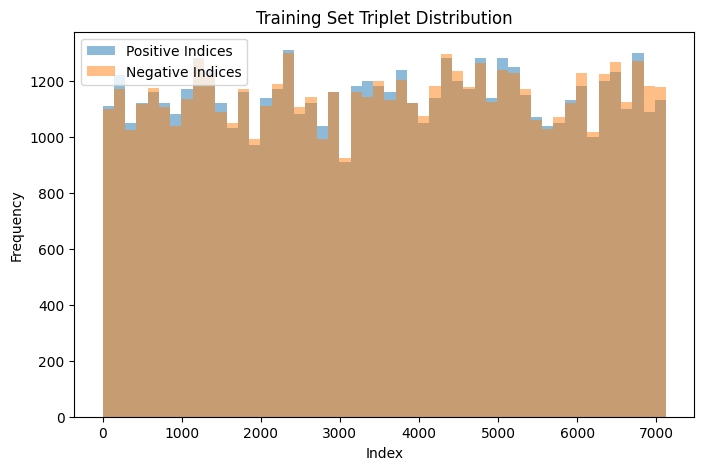

In [12]:
# Load the triplet data
with open('triplet_data/triplets_1_negatives.pickle', 'rb') as file:
    data = pickle.load(file)

# Unpack the data
audio_embeddings, audio_df, image_embeddings, image_df, triplets, triplets_train, triplets_val, triplets_test = data

# Print basic statistics about the datasets
print(f"Total triplets: {len(triplets)}")
print(f"Training triplets: {len(triplets_train)}")
print(f"Validation triplets: {len(triplets_val)}")
print(f"Test triplets: {len(triplets_test)}")

# Example of a few triplets
print("Sample triplets from the training set:")
for idx in range(5):
    print(f"Audio Index: {triplets_train[idx][0]}, Positive Image Index: {triplets_train[idx][1]}, Negative Image Index: {triplets_train[idx][2]}")

# Visualizing the balance of the dataset
def plot_triplet_distribution(triplets, title="Triplet Distribution"):
    positive_indices = [t[1] for t in triplets]
    negative_indices = [t[2] for t in triplets]

    plt.figure(figsize=(8, 5))
    plt.hist(positive_indices, alpha=0.5, label='Positive Indices', bins=50)
    plt.hist(negative_indices, alpha=0.5, label='Negative Indices', bins=50)
    plt.xlabel('Index')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.legend()
    plt.show()

plot_triplet_distribution(triplets_train, "Training Set Triplet Distribution")


In [13]:
v_index_to_key = {i: key for i, key in enumerate(audio_embeddings.keys())}
f_index_to_key = {i: key for i, key in enumerate(image_embeddings.keys())}

# Initialize the dataset with the training triplets
dataset = VoiceFaceDataset(audio_embeddings, image_embeddings, triplets_train, v_index_to_key, f_index_to_key)

# Show how to use the dataset
print("Sample triplets from the dataset:")
for i in range(5):
    voice, pos_face, neg_face, label = dataset[i]
    print(f"Voice Index: {triplets_train[i][0]}, Positive Face Index: {triplets_train[i][1]}, Negative Face Index: {triplets_train[i][2]}, Label: {label}")

Sample triplets from the dataset:
Voice Index: 0, Positive Face Index: 0, Negative Face Index: 1090, Label: [1.]
Voice Index: 0, Positive Face Index: 1, Negative Face Index: 6720, Label: [1.]
Voice Index: 0, Positive Face Index: 2, Negative Face Index: 6518, Label: [1.]
Voice Index: 0, Positive Face Index: 3, Negative Face Index: 6478, Label: [1.]
Voice Index: 0, Positive Face Index: 4, Negative Face Index: 4714, Label: [1.]


Saving results to folder: trained_VFTC_model
Feature batch shape: voice torch.Size([64, 192]), face torch.Size([64, 512])
Labels batch shape: torch.Size([64, 1])
[epoch 0, 5.08 sec] loss: train 0.699 val 0.694 accuracy: val 0.506 lr: 1.00e-03 
[epoch 1, 4.08 sec] loss: train 0.692 val 0.695 accuracy: val 0.501 lr: 9.95e-04 (*best validation loss*)
[epoch 2, 4.14 sec] loss: train 0.688 val 0.694 accuracy: val 0.506 lr: 9.90e-04 (*best validation loss*)
[epoch 3, 4.36 sec] loss: train 0.685 val 0.694 accuracy: val 0.522 lr: 9.85e-04 (*best validation loss*)
[epoch 4, 4.13 sec] loss: train 0.677 val 0.691 accuracy: val 0.531 lr: 9.80e-04 (*best validation loss*)
[epoch 5, 4.45 sec] loss: train 0.664 val 0.679 accuracy: val 0.567 lr: 9.75e-04 (*best validation loss*)
[epoch 6, 4.52 sec] loss: train 0.641 val 0.657 accuracy: val 0.609 lr: 9.70e-04 (*best validation loss*)
[epoch 7, 4.98 sec] loss: train 0.605 val 0.612 accuracy: val 0.653 lr: 9.66e-04 (*best validation loss*)
[epoch 8, 4.32

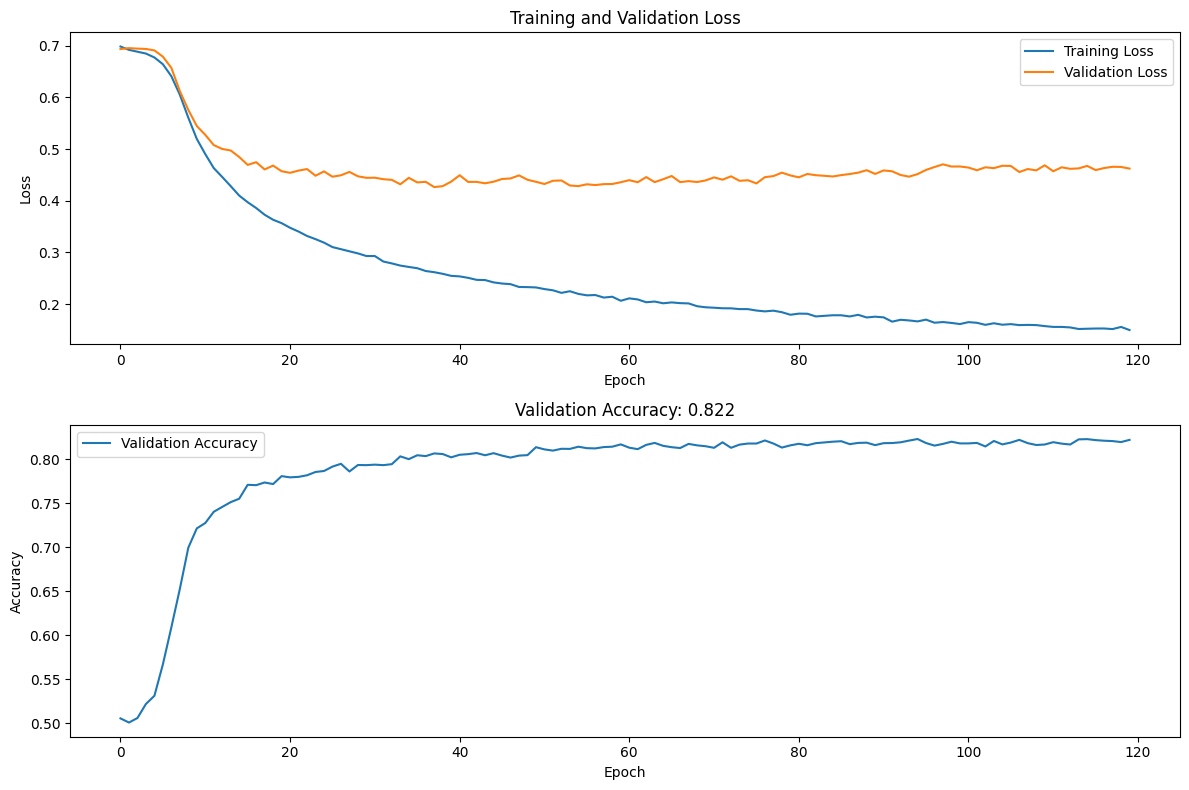

In [14]:
%run train_VFTC_model.py

In [15]:
# Running test
%run test_VFTC.py

Using CPU for evaluation.
Test Loss: 0.471
Test Accuracy: 0.823


Epoch 1, Loss: 0.450585731, Val Loss: 0.668626648, Val Accuracy: 50.9431%, LR: 0.0001000
Saved best model to trained_CLIP_models/best_model_epoch0.pth
Epoch 2, Loss: 0.338705803, Val Loss: 0.660375375, Val Accuracy: 50.3606%, LR: 0.0001000
Saved best model to trained_CLIP_models/best_model_epoch1.pth
Epoch 3, Loss: 0.335832568, Val Loss: 0.654328905, Val Accuracy: 50.8322%, LR: 0.0001000
Saved best model to trained_CLIP_models/best_model_epoch2.pth
Epoch 4, Loss: 0.335220858, Val Loss: 0.652742234, Val Accuracy: 50.3745%, LR: 0.0001000
Saved best model to trained_CLIP_models/best_model_epoch3.pth
Epoch 5, Loss: 0.335096586, Val Loss: 0.647073463, Val Accuracy: 51.7753%, LR: 0.0001000
Saved best model to trained_CLIP_models/best_model_epoch4.pth
Epoch 6, Loss: 0.334933741, Val Loss: 0.645812268, Val Accuracy: 51.1234%, LR: 0.0001000
Saved best model to trained_CLIP_models/best_model_epoch5.pth
Epoch 7, Loss: 0.334763892, Val Loss: 0.641351379, Val Accuracy: 50.4438%, LR: 0.0001000
Saved

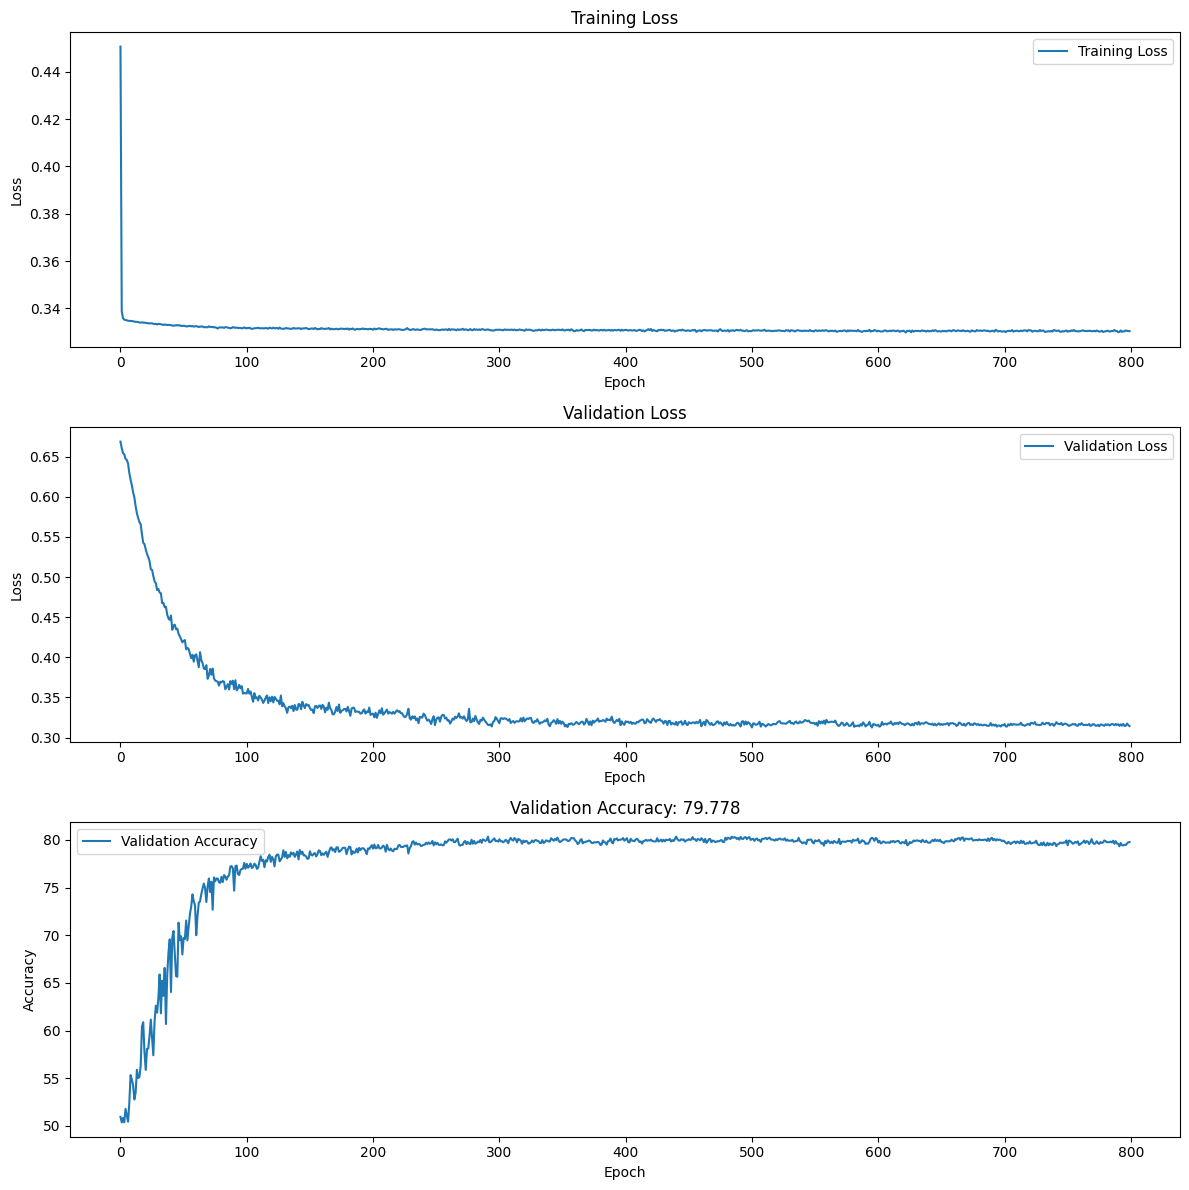

In [16]:
%run train_CLIP_model.py


In [17]:
%run test_CLIP.py

Identification Accuracy: 79.71%


Selected faces: dict_keys(['Amy_Dumas', 'Tom_Felton', 'Andrew_Lincoln', 'Matthew_Goode', 'James_Franco', 'Candace_Cameron-Bure'])
Ground truth: The selected voice embedding corresponds to Amy_Dumas
Ranked list of faces based on similarity to the voice embedding:
Rank 1: Amy_Dumas with similarity 0.8563
Rank 2: Candace_Cameron-Bure with similarity 0.3567
Rank 3: Andrew_Lincoln with similarity 0.3402
Rank 4: Tom_Felton with similarity 0.3387
Rank 5: Matthew_Goode with similarity 0.3348
Rank 6: James_Franco with similarity 0.3347


/app/ranked_list.py:75: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /root/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
  face_tensors = torch.tensor([selected_faces[k] for k in selected_faces.keys()])


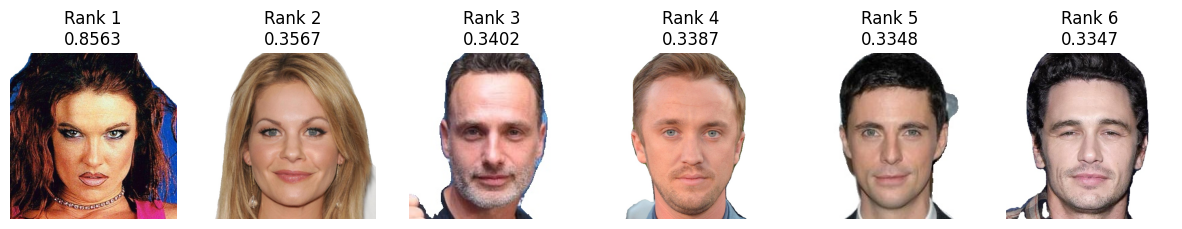

In [18]:
%run ranked_list.py